<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/01_MINI_ALADDIN_ALPHA/blob/main/ALPHA%20CON%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Configuración para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# 1. INGESTA DE DATOS (Multi-Asset para robustez)
# Usaremos NVDA (Alta volatilidad = Más oportunidad de Alpha) en lugar de SPY
ticker = "NVDA"
print(f"Descargando datos para {ticker}...")
data = yf.download(ticker, start="2018-01-01", end="2024-01-01", auto_adjust=True, progress=False)

# Aplanar MultiIndex si es necesario
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Feature Engineering: Solo Precio de Cierre para el MVP de DL
# En DL, menos es más al principio. Dejamos que la red extraiga las features latentes.
df = data[['Close']].copy()
dataset = df.values

# 2. NORMALIZACIÓN (CRÍTICO EN DEEP LEARNING)
# Las LSTMs son sensibles a la escala. Llevamos todo a [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 3. CREACIÓN DE SECUENCIAS (TENSORIZACIÓN)
# Transformamos la serie de tiempo en una estructura 3D: [Muestras, Pasos de Tiempo, Features]
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0]) # Los 60 días anteriores
        y.append(data[i, 0])              # El día siguiente (Target)
    return np.array(X), np.array(y)

time_steps = 60 # La red "mira" 2 meses atrás para decidir
X, y = create_sequences(scaled_data, time_steps)

# Reshape para LSTM [Samples, Time Steps, Features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Secuencial (Train 80% / Test 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Tensores creados.")
print(f"Shape Entrada: {X_train.shape} (Muestras, Ventana Temporal, Features)")

Descargando datos para NVDA...
Tensores creados.
Shape Entrada: (1159, 60, 1) (Muestras, Ventana Temporal, Features)


Iniciando entrenamiento (puede tardar unos minutos en CPU)...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0255 - val_loss: 0.0021
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 9.0411e-04 - val_loss: 0.0069
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 8.2965e-04 - val_loss: 0.0050
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 8.2389e-04 - val_loss: 0.0049
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 9.1931e-04 - val_loss: 0.0040
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 8.0172e-04 - val_loss: 0.0056
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - 

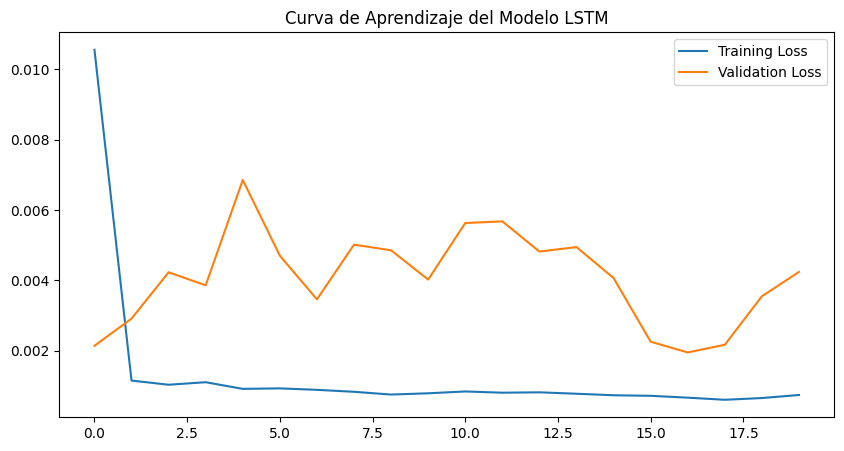

In [2]:
# 4. CONSTRUCCIÓN DEL MODELO LSTM
model = Sequential()

# Capa 1: LSTM con retorno de secuencias (para apilar otra LSTM)
# units=50: Dimensionalidad del espacio oculto (memoria)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Apaga el 20% de neuronas para evitar memorización (Overfitting)

# Capa 2: LSTM final
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Capa de Salida: Predicción del valor escalar (Precio normalizado)
model.add(Dense(units=1))

# Compilación: Optimizador Adam (Estándar en DL) y Loss MSE (Error Cuadrático Medio)
model.compile(optimizer='adam', loss='mean_squared_error')

print("Iniciando entrenamiento (puede tardar unos minutos en CPU)...")
# Entrenamiento
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Gráfica de Convergencia (Pérdida)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Aprendizaje del Modelo LSTM')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


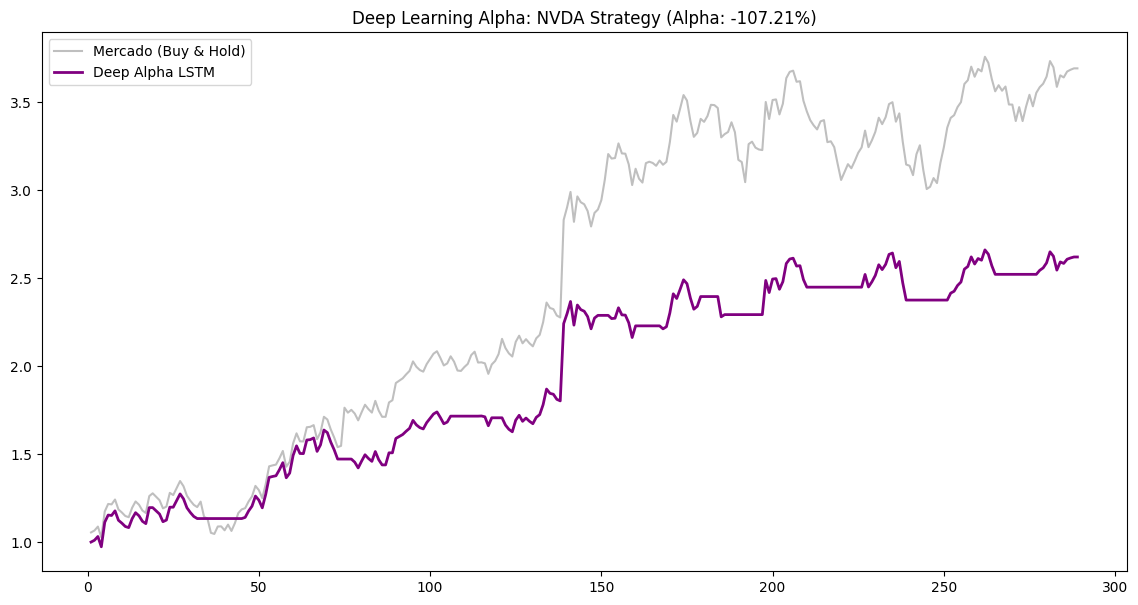

Retorno Acumulado Mercado: 269.25%
Retorno Acumulado LSTM:    162.04%


In [3]:
# 5. PREDICCIÓN
predicted_prices = model.predict(X_test)

# Des-normalizar para obtener precios reales en Dólares
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. ESTRATEGIA DE TRADING (GENERACIÓN DE ALPHA)
# Lógica: Si el modelo predice que el precio mañana > precio hoy, COMPRA (Long).
# Si predice precio mañana < precio hoy, VENTA/CASH (Short/Flat).

# Recuperamos el precio de "ayer" para comparar (usamos los datos reales para el shift)
# Ajuste de índices para alinear
results = pd.DataFrame({
    'Real_Price': real_prices.flatten(),
    'Predicted_Price': predicted_prices.flatten()
})

# Calculamos retornos esperados vs reales
results['Real_Return'] = results['Real_Price'].pct_change()
results['Predicted_Return'] = results['Predicted_Price'].pct_change()

# SEÑAL DE TRADING:
# 1 = Long (Predice subida), 0 = Cash (Predice bajada) -> Estrategia conservadora
# Para Alpha agresivo usaríamos -1 (Short), pero empecemos simple.
results['Signal'] = np.where(results['Predicted_Return'] > 0, 1, 0)

# Shift de la señal: La predicción de hoy se usa para operar el retorno de MAÑANA
results['Signal'] = results['Signal'].shift(1)

# Cálculo de Retornos de Estrategia
results['Strategy_Return'] = results['Signal'] * results['Real_Return']

# Limpieza de NaNs iniciales
results.dropna(inplace=True)

# 7. EVALUACIÓN DE ALPHA
results['Cum_Market'] = (1 + results['Real_Return']).cumprod()
results['Cum_Strategy'] = (1 + results['Strategy_Return']).cumprod()

alpha_total = results['Cum_Strategy'].iloc[-1] - results['Cum_Market'].iloc[-1]

# Visualización
plt.figure(figsize=(14, 7))
plt.plot(results['Cum_Market'], label='Mercado (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(results['Cum_Strategy'], label='Deep Alpha LSTM', color='purple', linewidth=2)
plt.title(f'Deep Learning Alpha: NVDA Strategy (Alpha: {alpha_total:.2%})')
plt.legend()
plt.show()

print(f"Retorno Acumulado Mercado: {(results['Cum_Market'].iloc[-1]-1)*100:.2f}%")
print(f"Retorno Acumulado LSTM:    {(results['Cum_Strategy'].iloc[-1]-1)*100:.2f}%")